In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44711,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33253,Total threads: 8
Dashboard: http://127.0.0.1:42345/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:38507,


In [2]:
import xarray as xr
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_ADCP.nc'
ds_adcp = xr.open_dataset(profile_path)
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_CUR.nc'
ds_cur = xr.open_dataset(profile_path)

In [68]:
print(ds_adcp.prof_V[0:50].values)

[[9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]
 [9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]
 [9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]
 ...
 [9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]
 [9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]
 [9.96920997e+36 9.96920997e+36 9.96920997e+36 ... 9.96920997e+36
  9.96920997e+36 9.96920997e+36]]


In [3]:
import pandas as pd
# Combine date and time into a datetime array
dates = ds_adcp['prof_YYYYMMDD'].values.astype(int)
times = ds_adcp['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_adcp = ds_adcp.assign_coords(time=('iPROF', datetimes))
# ds_adcp = ds_adcp.swap_dims({'iPROF': 'time'})
ds_adcp = ds_adcp.assign_coords(depth=('iDEPTH', ds_adcp['prof_depth'].values*-1))
# ds_adcp = ds_adcp.swap_dims({'iDEPTH': 'depth'})
ds_adcp = ds_adcp.assign_coords(lat=('iPROF', ds_adcp['prof_lat'].values))
ds_adcp = ds_adcp.assign_coords(lon=('iPROF', ds_adcp['prof_lon'].values))
# ds_adcp.set_index(lat='lat', lon='lon')
# Combine date and time into a datetime array
dates = ds_cur['prof_YYYYMMDD'].values.astype(int)
times = ds_cur['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_cur = ds_cur.assign_coords(time=('iPROF', datetimes))
# ds_cur = ds_cur.swap_dims({'iPROF': 'time'})
ds_cur = ds_cur.assign_coords(depth=('iDEPTH', ds_cur['prof_depth'].values*-1))
# ds_cur = ds_cur.swap_dims({'iDEPTH': 'depth'})
ds_cur = ds_cur.assign_coords(lat=('iPROF', ds_cur['prof_lat'].values))
ds_cur = ds_cur.assign_coords(lon=('iPROF', ds_cur['prof_lon'].values))
# ds_cur.set_index(lat='lat', lon='lon')

In [70]:
print(ds_adcp)

<xarray.Dataset> Size: 73MB
Dimensions:        (iPROF: 35132, iDEPTH: 62)
Coordinates:
    time           (iPROF) datetime64[ns] 281kB 2012-12-31T01:30:00 ... 2013-...
    depth          (iDEPTH) float64 496B -10.0 -15.0 -20.0 ... -310.0 -315.0
    lat            (iPROF) float64 281kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon            (iPROF) float64 281kB 250.0 250.0 250.0 ... 190.0 190.0 190.0
Dimensions without coordinates: iPROF, iDEPTH
Data variables:
    prof_YYYYMMDD  (iPROF) float64 281kB 2.012e+07 2.012e+07 ... 2.013e+07
    prof_HHMMSS    (iPROF) float64 281kB 1.3e+04 1.3e+04 ... 2.23e+05 2.23e+05
    prof_lon       (iPROF) float64 281kB 250.0 250.0 250.0 ... 190.0 190.0 190.0
    prof_lat       (iPROF) float64 281kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prof_depth     (iDEPTH) float64 496B 10.0 15.0 20.0 ... 305.0 310.0 315.0
    prof_descr     (iPROF) |S30 1MB ...
    prof_U         (iPROF, iDEPTH) float64 17MB ...
    prof_Uweight   (iPROF, iDEPTH) float64 17

<DatasetGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'lon': 4/4 groups present with labels 165.0, 190.0, 220.0, 250.0>


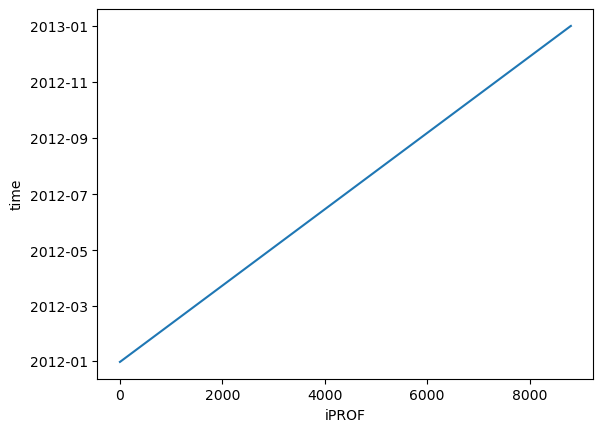

In [4]:
# group profiles by longitude (these are all equatorial TAO moorings)
adcp_by_lon = ds_adcp.groupby('lon')
# check that for a single longitude, time is monotonically increasing 
print(adcp_by_lon)
adcp_by_lon[220.0].time.plot()

<DatasetGroupBy, grouped over 1 grouper(s), 3 groups in total:
    'lon': 3/3 groups present with labels 147.0, 156.0, 190.0>


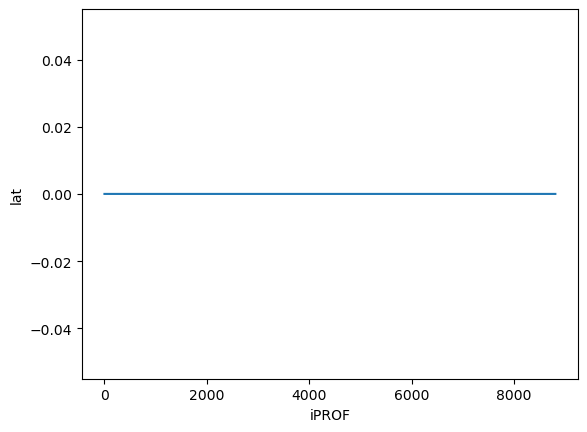

In [5]:
# group profiles by longitude (these are all equatorial TAO moorings)
cur_by_lon = ds_cur.groupby('lon')
# check that for a single longitude, time is monotonically increasing 
print(cur_by_lon)
cur_by_lon[190.0].lat.plot()

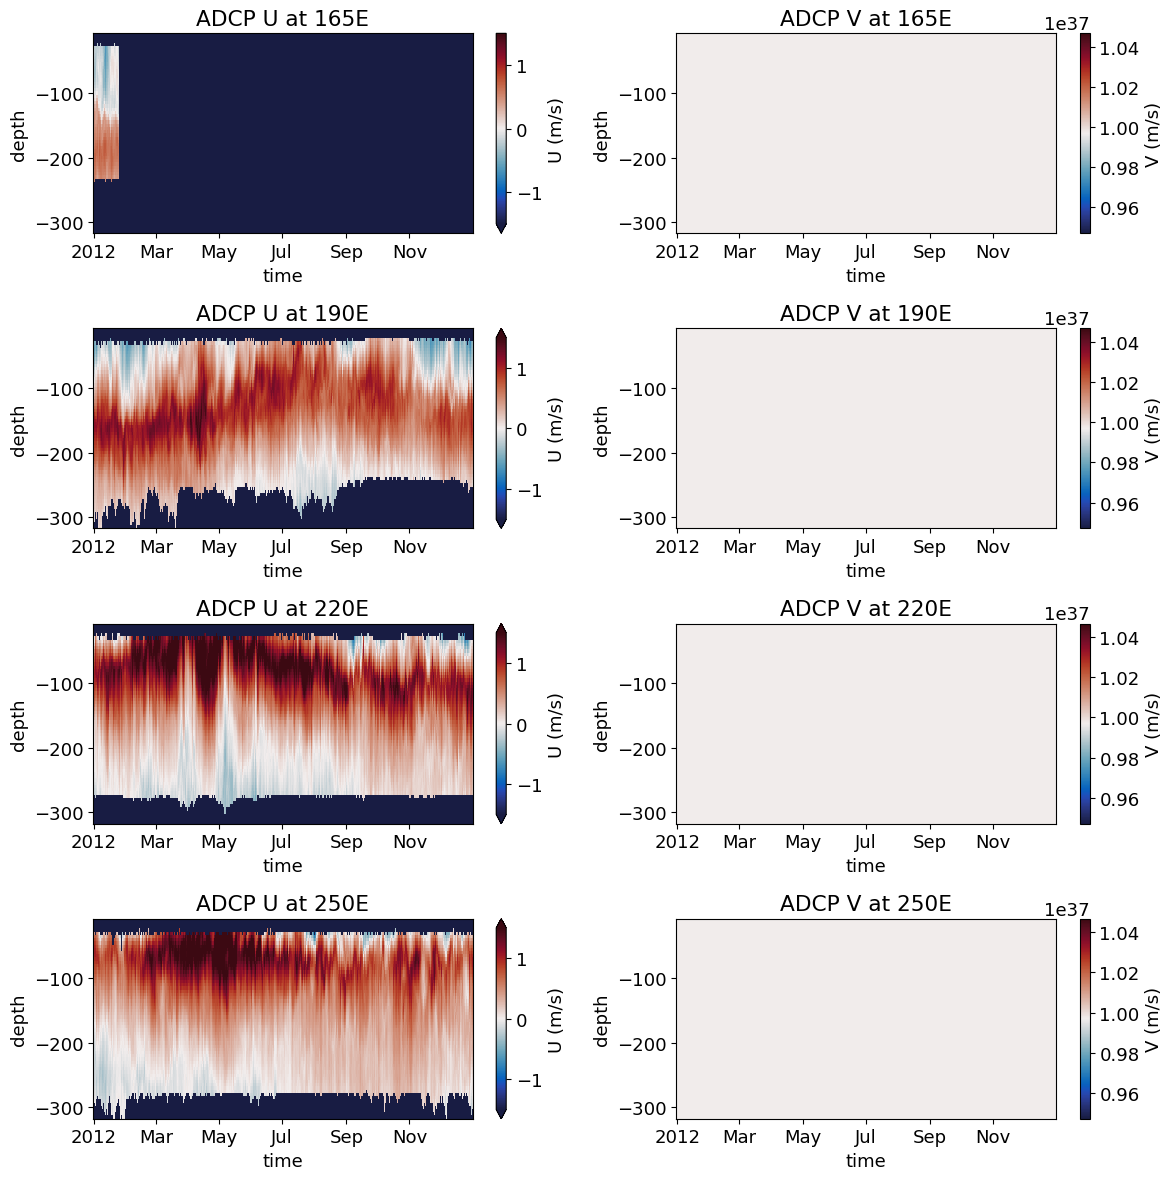

In [6]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import TwoSlopeNorm
import cmocean.cm as cmo
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize=(12,12),nrows=4, ncols=2)
adcp_by_lon[165.0].prof_U.T.plot(ax=ax[0,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('ADCP U at 165E')
adcp_by_lon[190.0].prof_U.T.plot(ax=ax[1,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_title('ADCP U at 190E')
adcp_by_lon[220.0].prof_U.T.plot(ax=ax[2,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('ADCP U at 140W')
adcp_by_lon[250.0].prof_U.T.plot(ax=ax[3,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[3,0].set_title('ADCP U at 250E')

adcp_by_lon[165.0].prof_V.T.plot(ax=ax[0,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[0,1].set_title('ADCP V at 165E')
adcp_by_lon[190.0].prof_V.T.plot(ax=ax[1,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[1,1].set_title('ADCP V at 190E')
adcp_by_lon[220.0].prof_V.T.plot(ax=ax[2,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[2,1].set_title('ADCP V at 140W')
adcp_by_lon[250.0].prof_V.T.plot(ax=ax[3,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[3,1].set_title('ADCP V at 250E')


plt.tight_layout()
plt.savefig('adcp_profiles_forTPOSE6.png')

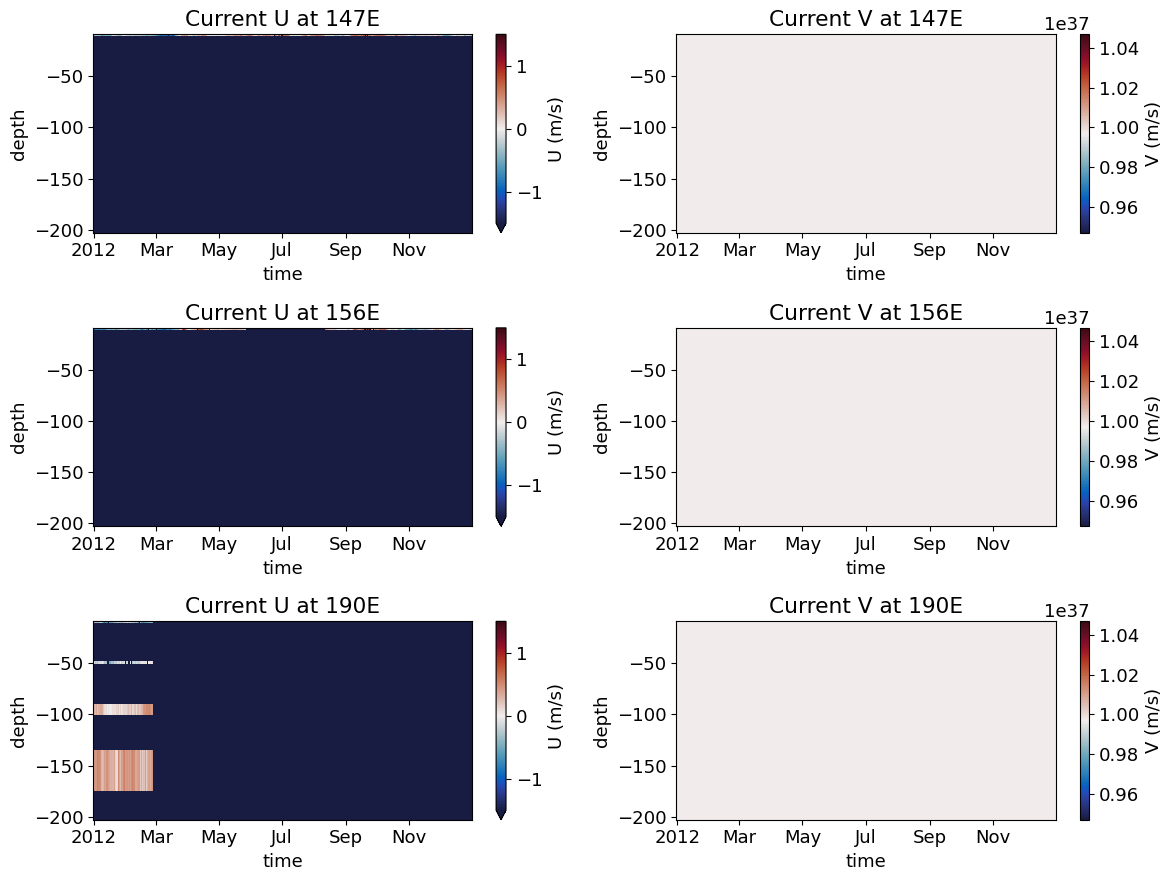

In [7]:
fig, ax = plt.subplots(figsize=(12,9),nrows=3, ncols=2)
cur_by_lon[147.0].prof_U.T.plot(ax=ax[0,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('Current U at 147E')
cur_by_lon[156.0].prof_U.T.plot(ax=ax[1,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_title('Current U at 156E')
cur_by_lon[190.0].prof_U.T.plot(ax=ax[2,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('Current U at 190E')

cur_by_lon[147.0].prof_V.T.plot(ax=ax[0,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[0,1].set_title('Current V at 147E')
cur_by_lon[156.0].prof_V.T.plot(ax=ax[1,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[1,1].set_title('Current V at 156E')
cur_by_lon[190.0].prof_V.T.plot(ax=ax[2,1],x='time',y='depth',cmap=cmo.balance,cbar_kwargs={'label': 'V (m/s)'})
ax[2,1].set_title('Current V at 190E')
plt.tight_layout()
plt.savefig('cur_profiles_forTPOSE6.png')

In [12]:
from xmitgcm import open_mdsdataset
data_dir = '/data/SO3/edavenport/tpose6/sep2012/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = ['diag_state']
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)

In [50]:
ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
U6_140 = ds.UVEL.interp(XG=[220.0],YC=[0.0],Z=adcp_by_lon[220.0].depth.values,time=adcp_by_lon[220.0].time.values,method='linear')

U6_TAO_140 = U6_140.copy(deep=True)
U6_TAO_140.values = adcp_by_lon[220.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_140.name = 'U6_TAO_140'
U6_TAO_140 = U6_TAO_140.where(U6_TAO_140 != -9999.0)

U6_110 = ds.UVEL.interp(XG=[250.0],YC=[0.0],Z=adcp_by_lon[250.0].depth.values,time=adcp_by_lon[250.0].time.values,method='linear')

U6_TAO_110 = U6_140.copy(deep=True)
U6_TAO_110.values = adcp_by_lon[250.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_110.name = 'U6_TAO_110'
U6_TAO_110 = U6_TAO_110.where(U6_TAO_110 != -9999.0)

U6_170 = ds.UVEL.interp(XG=[190.0],YC=[0.0],Z=adcp_by_lon[190.0].depth.values,time=adcp_by_lon[190.0].time.values,method='linear')

U6_TAO_170 = U6_170.copy(deep=True)
U6_TAO_170.values = adcp_by_lon[190.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_170.name = 'U6_TAO_170'
U6_TAO_170 = U6_TAO_170.where(U6_TAO_170 != -9999.0)

U6_165E = ds.UVEL.interp(XG=[165.0],YC=[0.0],Z=adcp_by_lon[165.0].depth.values,time=adcp_by_lon[165.0].time.values,method='linear')

U6_TAO_165E = U6_165E.copy(deep=True)
U6_TAO_165E.values = adcp_by_lon[165.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_165E.name = 'U6_TAO_165E'
U6_TAO_165E = U6_TAO_165E.where(U6_TAO_165E != -9999.0)

In [28]:
# look at RMS difference over time, look for outliers, look at the distribution/mean/std dev/kurtosis/skewness of the misfit,
# find misfit/std dev (some sort of relative error metric) top ten outliers
# print(U6_140)
U6_TAO_140[:,:,0,0].T

<xarray.DataArray 'U6_TAO_140' (Z: 62, time: 8807)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates: (12/13)
    iter     (time) float64 70kB dask.array<chunksize=(8807,), meta=np.ndarray>
    dyG      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    dxC      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    rAw      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    drF      (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
    PHrefC   (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
    ...       ...
    rhoRef   (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
  * time     (time) datetime64[ns] 70kB 2011-12-31T01:30:00 ... 2012-12-31T22...
    YC       float64 8B 0.0
    XG       float64 8B 220.0
  * Z        (Z) float64 496B -10.0 -15.0 -20.0 -25.0 ... -305.0 -310.0 -315.0
    maskW    (Z) bool 62B dask.array<chunksize=(38,), meta=np.ndarray>
Attributes:
    standard_name:  UVEL
    long_name:      Zonal Component of Velocity (m/s)
    units:          m/s
    mate:           VVEL

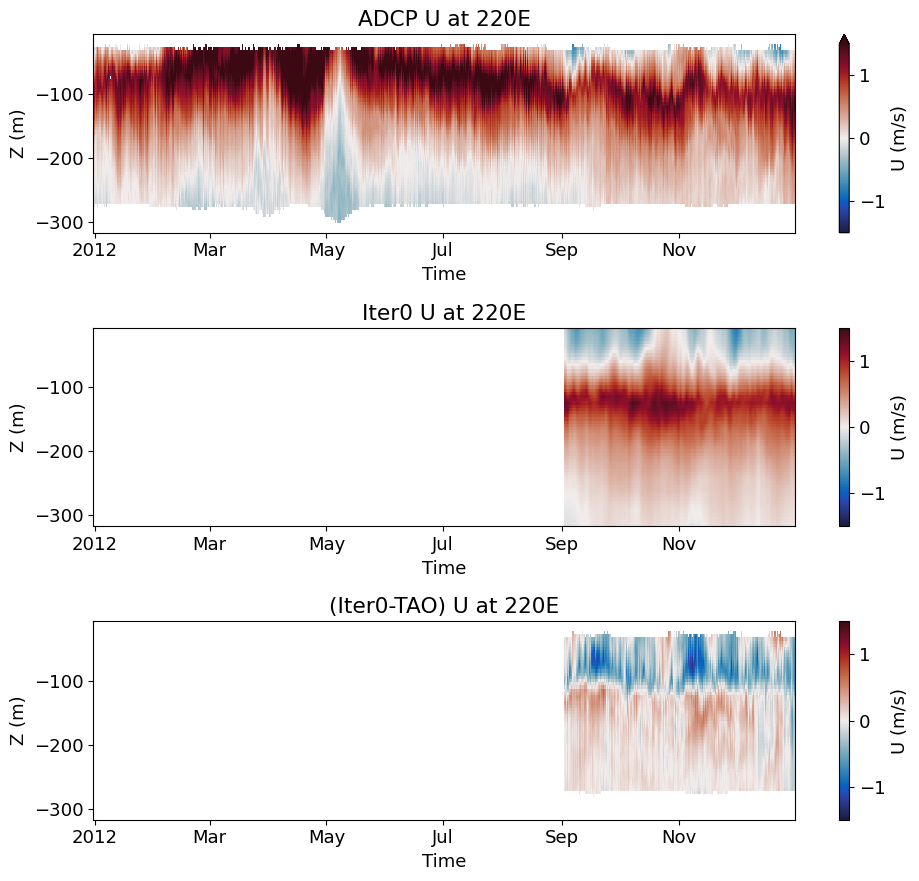

In [32]:
fig, ax = plt.subplots(figsize=(10,9),nrows=3, ncols=1)
U6_TAO_140[:,:,0,0].T.plot(ax=ax[0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0].set_title('ADCP U at 140W')
ax[0].set_ylabel('Z (m)')
U6_140[:,:,0,0].T.plot(ax=ax[1],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1].set_ylabel('Z (m)')
ax[1].set_title('Iter0 U at 140W')
diff = U6_140[:,:,0,0] - U6_TAO_140[:,:,0,0]
diff.T.plot(ax=ax[2],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2].set_title('(Iter0-TAO) U at 140W')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('adcp_profiles_vs_Iter0.png')

In [35]:
U6_TAO_140[:,:,0,0].sel(time=slice('2012-09-01', None))

<xarray.DataArray 'U6_TAO_140' (time: 2928, Z: 62)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates: (12/13)
    iter     (time) float64 23kB dask.array<chunksize=(2928,), meta=np.ndarray>
    dyG      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    dxC      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    rAw      >f4 4B dask.array<chunksize=(), meta=np.ndarray>
    drF      (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
    PHrefC   (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
    ...       ...
    rhoRef   (Z) >f4 248B dask.array<chunksize=(62,), meta=np.ndarray>
  * time     (time) datetime64[ns] 23kB 2012-09-01 ... 2012-12-31T22:30:00
    YC       float64 8B 0.0
    XG       float64 8B 220.0
  * Z        (Z) float64 496B -10.0 -15.0 -20.0 -25.0 ... -305.0 -310.0 -315.0
    maskW    (Z) bool 62B dask.array<chunksize=(38,), meta=np.ndarray>
Attributes:
    standard_name:  UVEL
    long_name:      Zonal Component of Velocity (m/s)
    units:          m/s
    mate:           VVEL

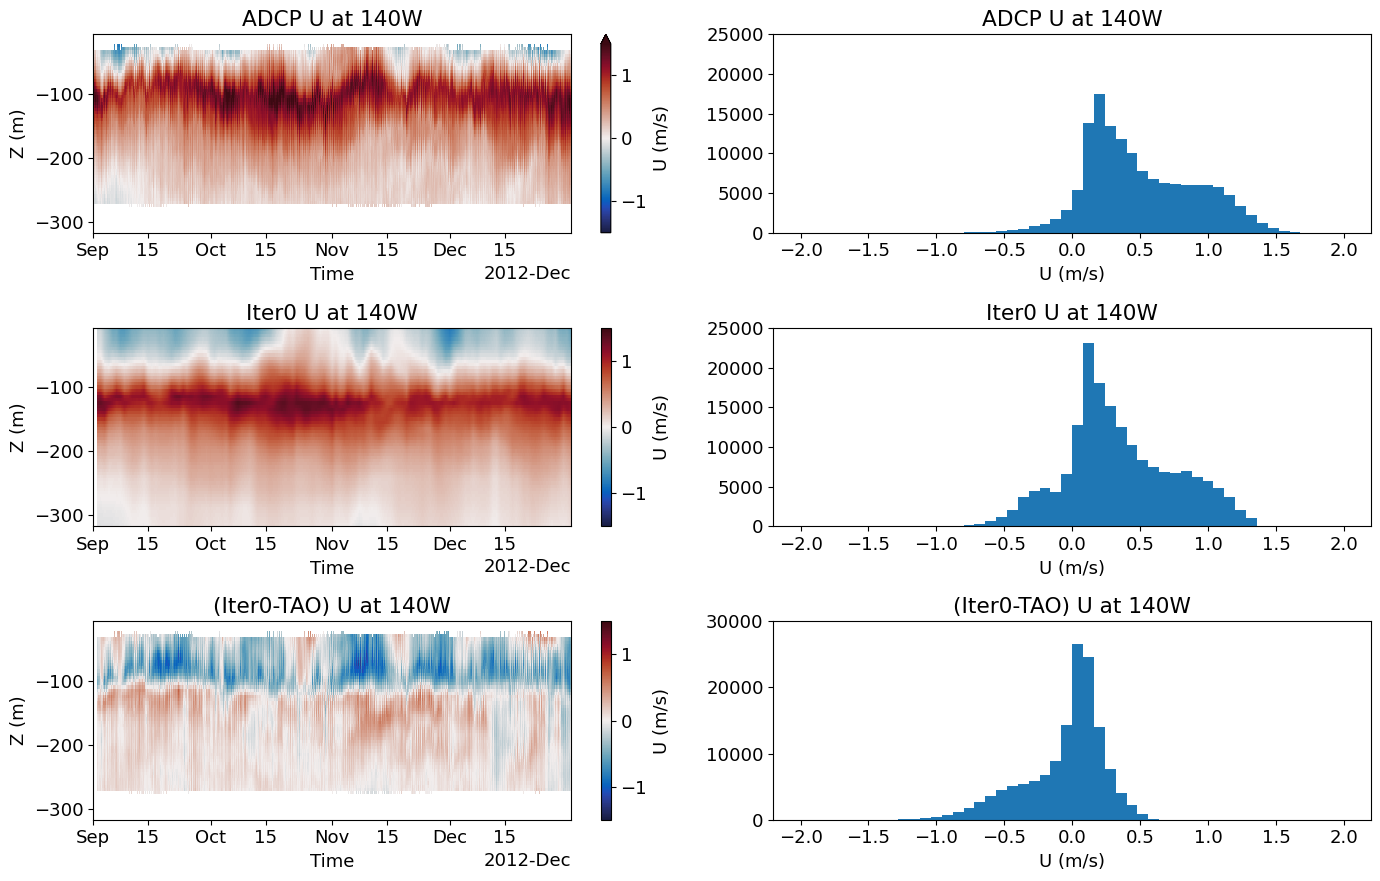

In [55]:
vmin = -2.0
vmax = 2.0
nbins = 50

# Create bin edges
bins = np.linspace(vmin, vmax, nbins + 1)

fig, ax = plt.subplots(figsize=(14,9),nrows=3, ncols=2)
U6_TAO_140[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[0,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('ADCP U at 140W')
ax[0,0].set_ylabel('Z (m)')
U6_140[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[1,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_title('Iter0 U at 140W')
diff = U6_140[:,:,0,0] - U6_TAO_140[:,:,0,0]
diff[:].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[2,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('(Iter0-TAO) U at 140W')
ax[2,0].set_ylabel('Z (m)')

U6_TAO_140[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[0,1],bins=bins)
ax[0,1].set_ylim(0,25000)
ax[0,1].set_title('ADCP U at 140W')
ax[0,1].set_xlabel('U (m/s)')
U6_140[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[1,1],bins=bins)
ax[1,1].set_title('Iter0 U at 140W')
ax[1,1].set_ylim(0,25000)
ax[1,1].set_xlabel('U (m/s)')
diff.sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[2,1],bins=bins)
ax[2,1].set_title('(Iter0-TAO) U at 140W')
ax[2,1].set_ylim(0,30000)
ax[2,1].set_xlabel('U (m/s)')

plt.tight_layout()
plt.savefig('adcp_U_vs_Iter0_hist_140W.png')

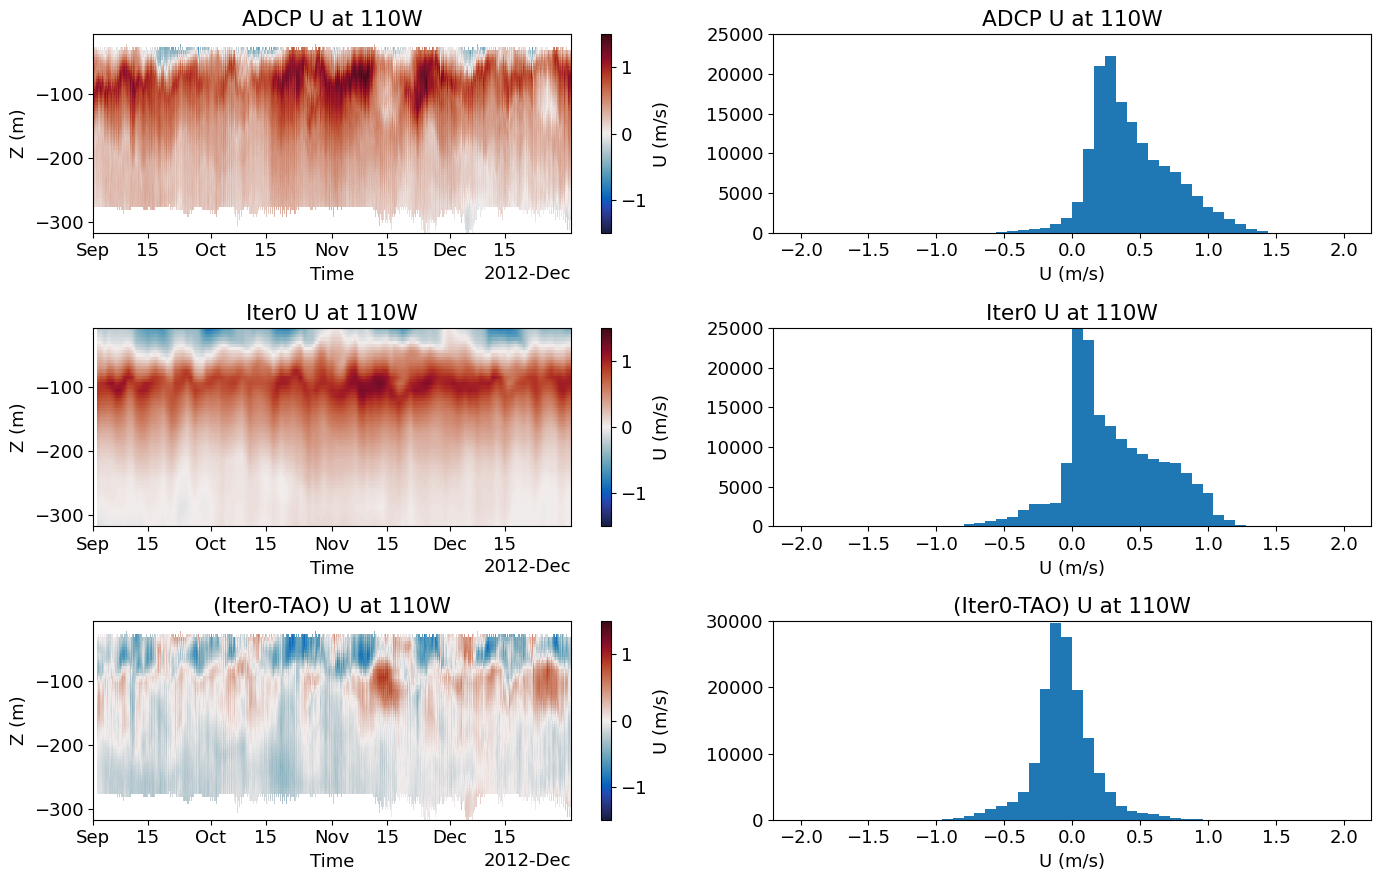

In [52]:
fig, ax = plt.subplots(figsize=(14,9),nrows=3, ncols=2)
U6_TAO_110[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[0,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('ADCP U at 110W')
ax[0,0].set_ylabel('Z (m)')
U6_110[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[1,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_title('Iter0 U at 110W')
diff = U6_110[:,:,0,0] - U6_TAO_110[:,:,0,0]
diff[:].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[2,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('(Iter0-TAO) U at 110W')
ax[2,0].set_ylabel('Z (m)')

U6_TAO_110[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[0,1],bins=bins)
ax[0,1].set_ylim(0,25000)
ax[0,1].set_title('ADCP U at 110W')
ax[0,1].set_xlabel('U (m/s)')
U6_110[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[1,1],bins=bins)
ax[1,1].set_title('Iter0 U at 110W')
ax[1,1].set_ylim(0,25000)
ax[1,1].set_xlabel('U (m/s)')
diff.sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[2,1],bins=bins)
ax[2,1].set_title('(Iter0-TAO) U at 110W')
ax[2,1].set_ylim(0,30000)
ax[2,1].set_xlabel('U (m/s)')

plt.tight_layout()
plt.savefig('adcp_U_vs_Iter0_hist_110W.png')

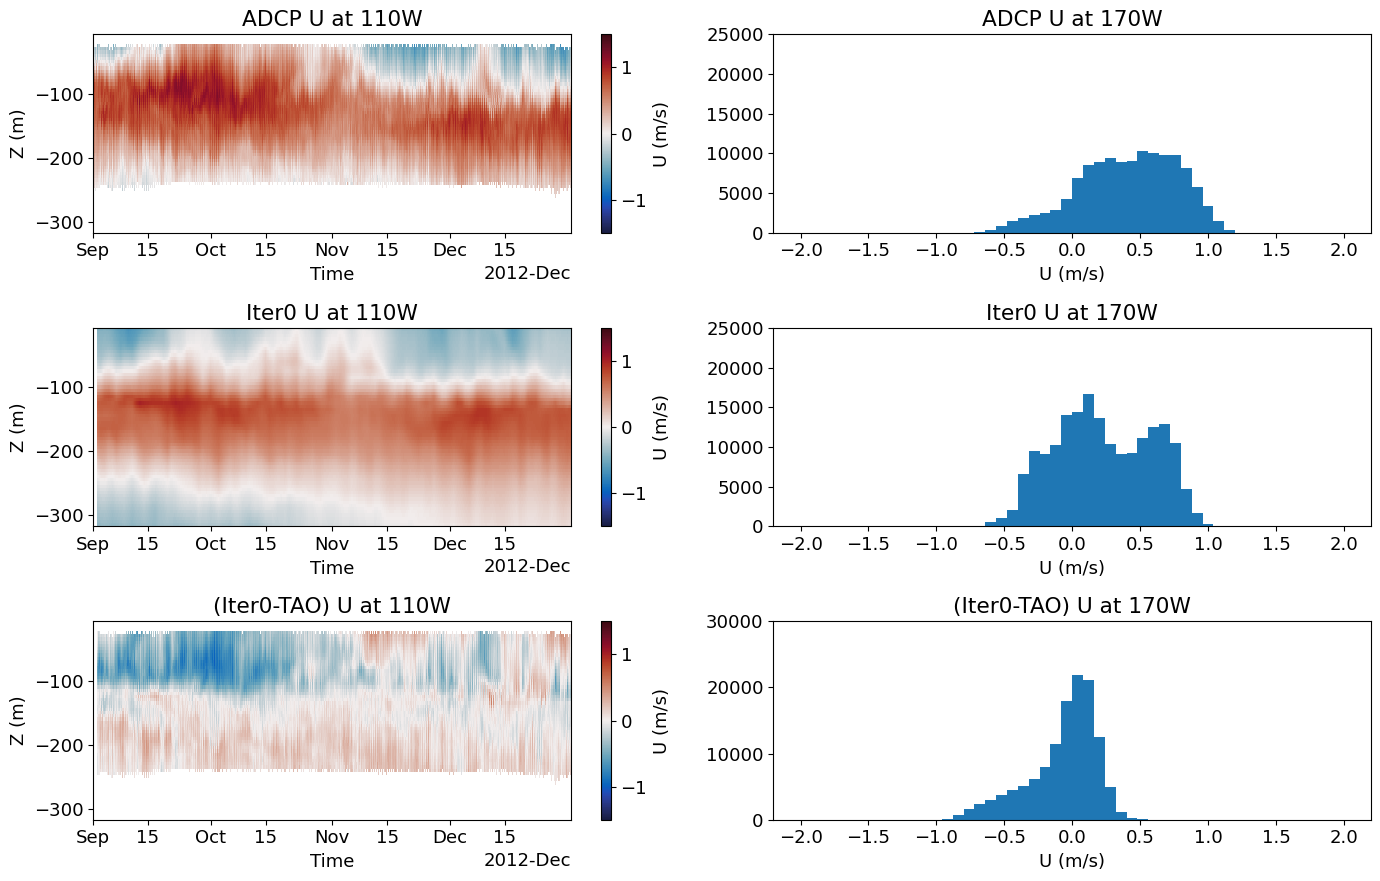

In [53]:
fig, ax = plt.subplots(figsize=(14,9),nrows=3, ncols=2)
U6_TAO_170[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[0,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('ADCP U at 110W')
ax[0,0].set_ylabel('Z (m)')
U6_170[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[1,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_title('Iter0 U at 110W')
diff = U6_170[:,:,0,0] - U6_TAO_170[:,:,0,0]
diff[:].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[2,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('(Iter0-TAO) U at 110W')
ax[2,0].set_ylabel('Z (m)')

U6_TAO_170[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[0,1],bins=bins)
ax[0,1].set_ylim(0,25000)
ax[0,1].set_title('ADCP U at 170W')
ax[0,1].set_xlabel('U (m/s)')
U6_170[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[1,1],bins=bins)
ax[1,1].set_title('Iter0 U at 170W')
ax[1,1].set_ylim(0,25000)
ax[1,1].set_xlabel('U (m/s)')
diff.sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[2,1],bins=bins)
ax[2,1].set_title('(Iter0-TAO) U at 170W')
ax[2,1].set_ylim(0,30000)
ax[2,1].set_xlabel('U (m/s)')

plt.tight_layout()
plt.savefig('adcp_U_vs_Iter0_hist_170W.png')

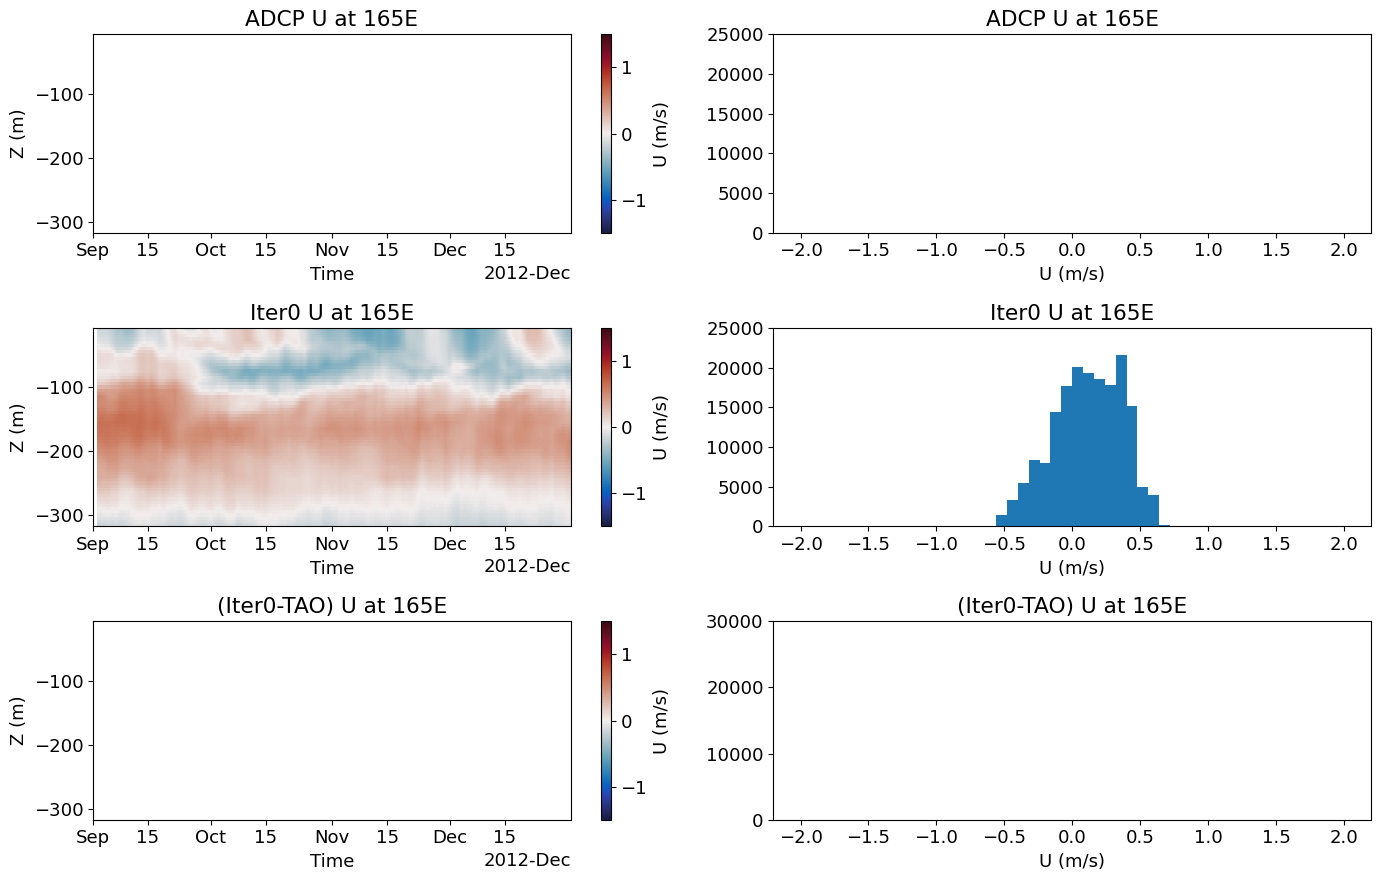

In [54]:
fig, ax = plt.subplots(figsize=(14,9),nrows=3, ncols=2)
U6_TAO_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[0,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0,0].set_title('ADCP U at 165E')
ax[0,0].set_ylabel('Z (m)')
U6_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[1,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1,0].set_ylabel('Z (m)')
ax[1,0].set_title('Iter0 U at 165E')
diff = U6_165E[:,:,0,0] - U6_TAO_165E[:,:,0,0]
diff[:].sel(time=slice('2012-09-01', None)).T.plot(ax=ax[2,0],x='time',y='Z',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2,0].set_title('(Iter0-TAO) U at 165E')
ax[2,0].set_ylabel('Z (m)')

U6_TAO_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[0,1],bins=bins)
ax[0,1].set_ylim(0,25000)
ax[0,1].set_title('ADCP U at 165E')
ax[0,1].set_xlabel('U (m/s)')
U6_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[1,1],bins=bins)
ax[1,1].set_title('Iter0 U at 165E')
ax[1,1].set_ylim(0,25000)
ax[1,1].set_xlabel('U (m/s)')
diff.sel(time=slice('2012-09-01', None)).plot.hist(ax=ax[2,1],bins=bins)
ax[2,1].set_title('(Iter0-TAO) U at 165E')
ax[2,1].set_ylim(0,30000)
ax[2,1].set_xlabel('U (m/s)')

plt.tight_layout()
plt.savefig('adcp_U_vs_Iter0_hist_165E.png')

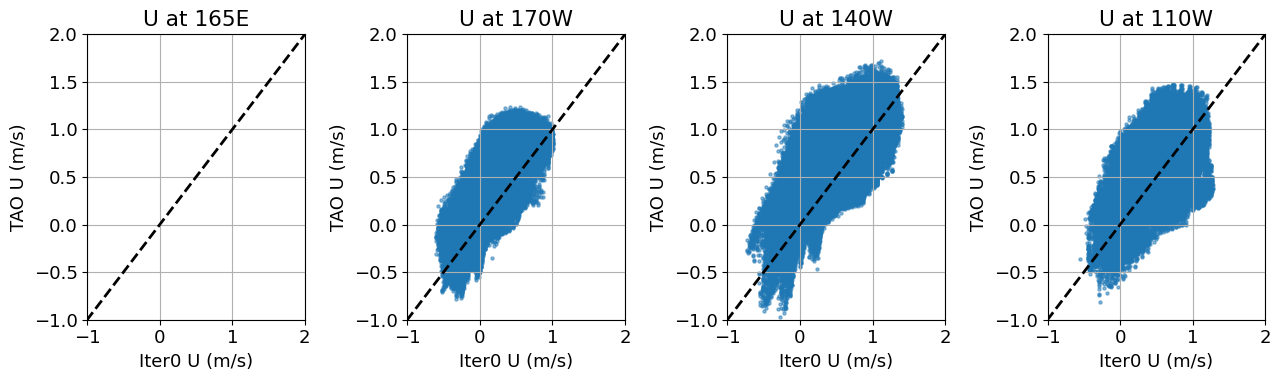

In [57]:

# Plot
fig, ax = plt.subplots(figsize=(13,4),ncols=4)

# Flatten and drop NaNs for a clean plot
x = U6_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
y = U6_TAO_165E[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
ax[0].scatter(x, y, s=5, alpha=0.5)
ax[0].set_title('U at 165E')
ax[0].set_ylabel('TAO U (m/s)')
ax[0].set_xlabel('Iter0 U (m/s)')
ax[0].grid(True)
ax[0].plot([-1.5,2.0],[-1.5,2.0], 'k--', lw=2)  # 1:1 line
ax[0].set_xlim(-1.0, 2.0)
ax[0].set_ylim(-1.0, 2.0)

# Flatten and drop NaNs for a clean plot
x = U6_170[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
y = U6_TAO_170[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
ax[1].scatter(x, y, s=5, alpha=0.5)
ax[1].set_title('U at 170W')
ax[1].set_ylabel('TAO U (m/s)')
ax[1].set_xlabel('Iter0 U (m/s)')
ax[1].grid(True)
ax[1].plot([-1.5,2.0],[-1.5,2.0], 'k--', lw=2)  # 1:1 line
ax[1].set_xlim(-1.0, 2.0)
ax[1].set_ylim(-1.0, 2.0)

# Flatten and drop NaNs for a clean plot
x = U6_140[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
y = U6_TAO_140[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
ax[2].scatter(x, y, s=5, alpha=0.5)
ax[2].set_title('U at 140W')
ax[2].set_ylabel('TAO U (m/s)')
ax[2].set_xlabel('Iter0 U (m/s)')
ax[2].grid(True)
ax[2].plot([-1.5,2.0],[-1.5,2.0], 'k--', lw=2)  # 1:1 line
ax[2].set_xlim(-1.0, 2.0)
ax[2].set_ylim(-1.0, 2.0)

# Flatten and drop NaNs for a clean plot
x = U6_110[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
y = U6_TAO_110[:,:,0,0].sel(time=slice('2012-09-01', None)).values.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
ax[3].scatter(x, y, s=5, alpha=0.5)
ax[3].set_title('U at 110W')
ax[3].set_ylabel('TAO U (m/s)')
ax[3].set_xlabel('Iter0 U (m/s)')
ax[3].grid(True)
ax[3].plot([-1.5,2.0],[-1.5,2.0], 'k--', lw=2)  # 1:1 line
ax[3].set_xlim(-1.0, 2.0)
ax[3].set_ylim(-1.0, 2.0)


plt.tight_layout()
plt.savefig('adcp_iter0_scatter.png')

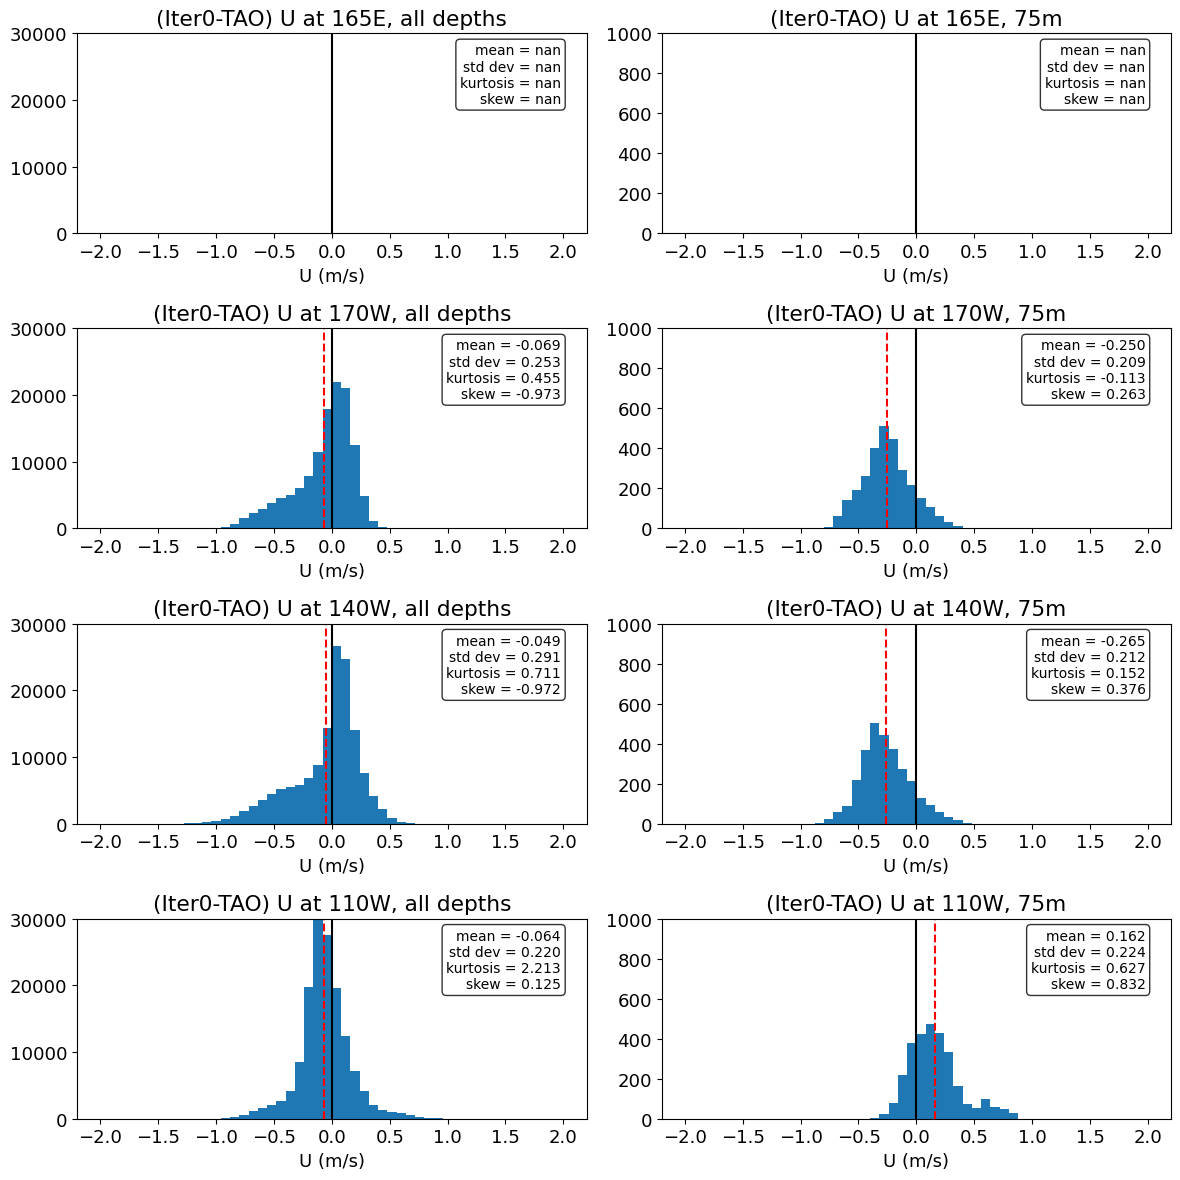

In [89]:
# look at RMS difference over time, look for outliers, look at the distribution/mean/std dev/kurtosis/skewness of the misfit,
from scipy.stats import kurtosis, skew

vmin = -2.0
vmax = 2.0
nbins = 50

# Create bin edges
bins = np.linspace(vmin, vmax, nbins + 1)

fig, ax = plt.subplots(figsize=(12,12),nrows=4, ncols=2)
diff = (U6_165E[:,:,0,0] - U6_TAO_165E[:,:,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[0,0],bins=bins)
ax[0,0].set_title('(Iter0-TAO) U at 165E, all depths')
ax[0,0].set_ylim(0,30000)
ax[0,0].set_xlabel('U (m/s)')
ax[0,0].axvline(0.0,color='k')
ax[0,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[0,0].text(
    0.95, 0.95, textstr,
    transform=ax[0,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_170[:,:,0,0] - U6_TAO_170[:,:,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[1,0],bins=bins)
ax[1,0].set_title('(Iter0-TAO) U at 170W, all depths')
ax[1,0].set_ylim(0,30000)
ax[1,0].set_xlabel('U (m/s)')
ax[1,0].axvline(0.0,color='k')
ax[1,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[1,0].text(
    0.95, 0.95, textstr,
    transform=ax[1,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_140[:,:,0,0] - U6_TAO_140[:,:,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[2,0],bins=bins)
ax[2,0].set_title('(Iter0-TAO) U at 140W, all depths')
ax[2,0].set_ylim(0,30000)
ax[2,0].set_xlabel('U (m/s)')
ax[2,0].axvline(0.0,color='k')
ax[2,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[2,0].text(
    0.95, 0.95, textstr,
    transform=ax[2,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_110[:,:,0,0] - U6_TAO_110[:,:,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[3,0],bins=bins)
ax[3,0].set_title('(Iter0-TAO) U at 110W, all depths')
ax[3,0].set_ylim(0,30000)
ax[3,0].set_xlabel('U (m/s)')
ax[3,0].axvline(0.0,color='k')
ax[3,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[3,0].text(
    0.95, 0.95, textstr,
    transform=ax[3,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

depths = ds.Z.values
depthidx = np.argmin(np.abs(depths - -75.0))  # Find index for depth 75m

diff = (U6_165E[:,depthidx,0,0] - U6_TAO_165E[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[0,1],bins=bins)
ax[0,1].set_title('(Iter0-TAO) U at 165E, 75m')
ax[0,1].set_ylim(0,1000)
ax[0,1].set_xlabel('U (m/s)')
ax[0,1].axvline(0.0,color='k')
ax[0,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[0,1].text(
    0.95, 0.95, textstr,
    transform=ax[0,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_170[:,depthidx,0,0] - U6_TAO_170[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[1,1],bins=bins)
ax[1,1].set_title('(Iter0-TAO) U at 170W, 75m')
ax[1,1].set_ylim(0,1000)
ax[1,1].set_xlabel('U (m/s)')
ax[1,1].axvline(0.0,color='k')
ax[1,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[1,1].text(
    0.95, 0.95, textstr,
    transform=ax[1,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_140[:,depthidx,0,0] - U6_TAO_140[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[2,1],bins=bins)
ax[2,1].set_title('(Iter0-TAO) U at 140W, 75m')
ax[2,1].set_ylim(0,1000)
ax[2,1].set_xlabel('U (m/s)')
ax[2,1].axvline(0.0,color='k')
ax[2,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[2,1].text(
    0.95, 0.95, textstr,
    transform=ax[2,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_110[:,depthidx,0,0] - U6_TAO_110[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
mean_diff = diff.mean().values
std_diff = diff.std().values
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
kurt_diff = kurtosis(flat_nonan,axis=None)
skew_diff = skew(flat_nonan,axis=None)
diff.plot.hist(ax=ax[3,1],bins=bins)
ax[3,1].set_title('(Iter0-TAO) U at 110W, 75m')
ax[3,1].set_ylim(0,1000)
ax[3,1].set_xlabel('U (m/s)')
ax[3,1].axvline(0.0,color='k')
ax[3,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"mean = {mean_diff:.3f}\nstd dev = {std_diff:.3f}\nkurtosis = {kurt_diff:.3f}\nskew = {skew_diff:.3f}"

# Add text box
ax[3,1].text(
    0.95, 0.95, textstr,
    transform=ax[3,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.savefig('adcp_iter0_misfit_stats.png')

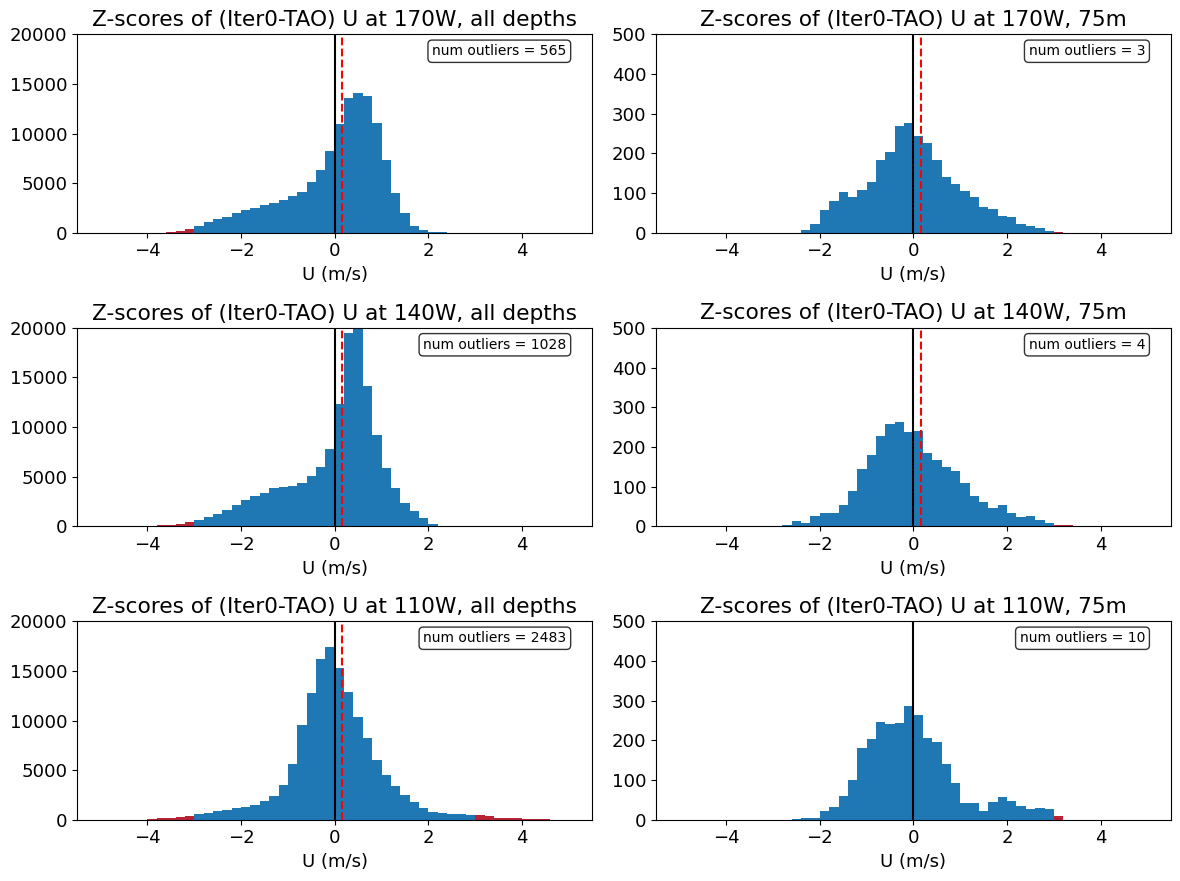

In [102]:
from scipy.stats import zscore
bins = np.linspace(-5, 5, 51)

fig, ax = plt.subplots(figsize=(12,9),nrows=3, ncols=2)
diff = (U6_170[:,:,0,0] - U6_TAO_170[:,:,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[0,0].hist(z_scores,bins=bins)
ax[0,0].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[0,0].set_title('Z-scores of (Iter0-TAO) U at 170W, all depths')
ax[0,0].set_ylim(0,20000)
ax[0,0].set_xlabel('U (m/s)')
ax[0,0].axvline(0.0,color='k')
ax[0,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[0,0].text(
    0.95, 0.95, textstr,
    transform=ax[0,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_140[:,:,0,0] - U6_TAO_140[:,:,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[1,0].hist(z_scores,bins=bins)
ax[1,0].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[1,0].set_title('Z-scores of (Iter0-TAO) U at 140W, all depths')
ax[1,0].set_ylim(0,20000)
ax[1,0].set_xlabel('U (m/s)')
ax[1,0].axvline(0.0,color='k')
ax[1,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[1,0].text(
    0.95, 0.95, textstr,
    transform=ax[1,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_110[:,:,0,0] - U6_TAO_110[:,:,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[2,0].hist(z_scores,bins=bins)
ax[2,0].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[2,0].set_title('Z-scores of (Iter0-TAO) U at 110W, all depths')
ax[2,0].set_ylim(0,20000)
ax[2,0].set_xlabel('U (m/s)')
ax[2,0].axvline(0.0,color='k')
ax[2,0].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[2,0].text(
    0.95, 0.95, textstr,
    transform=ax[2,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

depths = ds.Z.values
depthidx = np.argmin(np.abs(depths - -75.0))  # Find index for depth 75m

diff = (U6_170[:,depthidx,0,0] - U6_TAO_170[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[0,1].hist(z_scores,bins=bins)
ax[0,1].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[0,1].set_title('Z-scores of (Iter0-TAO) U at 170W, 75m')
ax[0,1].set_ylim(0,500)
ax[0,1].set_xlabel('U (m/s)')
ax[0,1].axvline(0.0,color='k')
ax[0,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[0,1].text(
    0.95, 0.95, textstr,
    transform=ax[0,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_140[:,depthidx,0,0] - U6_TAO_140[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[1,1].hist(z_scores,bins=bins)
ax[1,1].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[1,1].set_title('Z-scores of (Iter0-TAO) U at 140W, 75m')
ax[1,1].set_ylim(0,500)
ax[1,1].set_xlabel('U (m/s)')
ax[1,1].axvline(0.0,color='k')
ax[1,1].axvline(mean_diff,color='r', linestyle='--')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[1,1].text(
    0.95, 0.95, textstr,
    transform=ax[1,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

diff = (U6_110[:,depthidx,0,0] - U6_TAO_110[:,depthidx,0,0]).sel(time=slice('2012-09-01', None))
flat_nonan = diff.values.flatten()
flat_nonan = flat_nonan[~np.isnan(flat_nonan)]
z_scores = zscore(flat_nonan)
num_outliers = len(z_scores[np.abs(z_scores) > 3])
ax[2,1].hist(z_scores,bins=bins)
ax[2,1].hist(z_scores[np.abs(z_scores) > 3], bins=bins, color='red', alpha=0.7, label='Outliers (z > 3)')
ax[2,1].set_title('Z-scores of (Iter0-TAO) U at 110W, 75m')
ax[2,1].set_ylim(0,500)
ax[2,1].set_xlabel('U (m/s)')
ax[2,1].axvline(0.0,color='k')

# Format text
textstr = f"num outliers = {num_outliers:.0f}"

# Add text box
ax[2,1].text(
    0.95, 0.95, textstr,
    transform=ax[2,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('adcp_iter0_outliers.png')


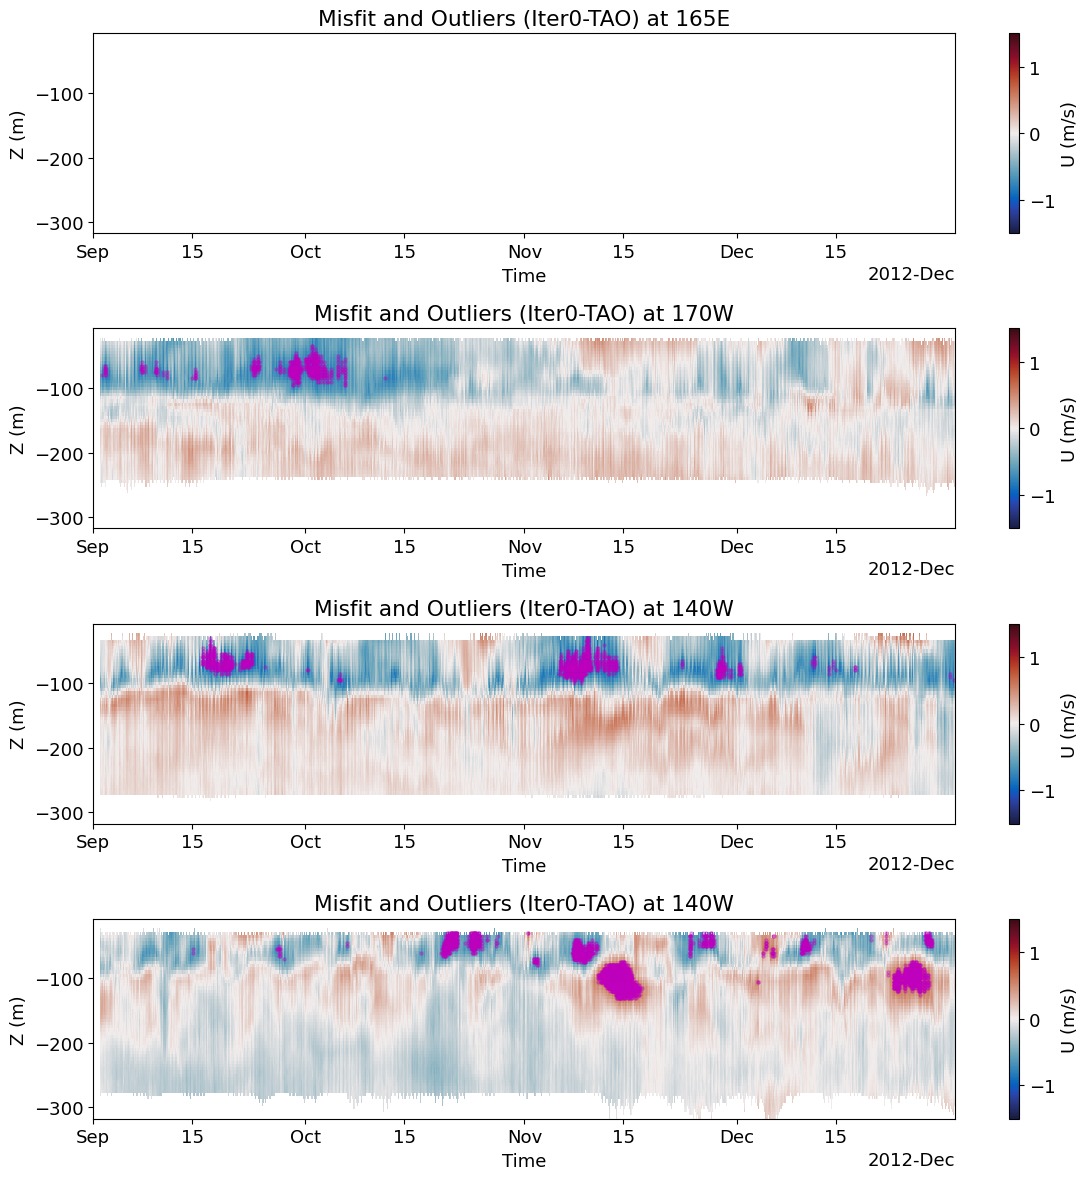

In [151]:

fig, ax = plt.subplots(figsize=(12,12),nrows=4)
diff = (U6_165E[:,:,0,0] - U6_TAO_165E[:,:,0,0]).sel(time=slice('2012-09-01', None))
z_scores = (diff - diff.mean()) / diff.std()
outlier_mask = np.abs(z_scores.values) > 3
time_idx, depth_idx = np.nonzero(outlier_mask) 
depth_vals = diff.Z.values[depth_idx] 
time_vals = diff.time.values[time_idx]
diff.T.plot(ax=ax[0], cmap=cmo.balance, vmin=-1.5, vmax=1.5, cbar_kwargs={'label': 'U (m/s)'})
ax[0].scatter(time_vals, depth_vals, color='m', s=5, alpha=0.3)
ax[0].set_title('Misfit and Outliers (Iter0-TAO) at 165E')
ax[0].set_ylabel('Z (m)')

diff = (U6_170[:,:,0,0] - U6_TAO_170[:,:,0,0]).sel(time=slice('2012-09-01', None))
z_scores = (diff - diff.mean()) / diff.std()
outlier_mask = np.abs(z_scores.values) > 3
time_idx, depth_idx = np.nonzero(outlier_mask) 
depth_vals = diff.Z.values[depth_idx] 
time_vals = diff.time.values[time_idx]
diff.T.plot(ax=ax[1], cmap=cmo.balance, vmin=-1.5, vmax=1.5, cbar_kwargs={'label': 'U (m/s)'})
ax[1].scatter(time_vals, depth_vals, color='m', s=5, alpha=0.3)
ax[1].set_title('Misfit and Outliers (Iter0-TAO) at 170W')
ax[1].set_ylabel('Z (m)')

diff = (U6_140[:,:,0,0] - U6_TAO_140[:,:,0,0]).sel(time=slice('2012-09-01', None))
z_scores = (diff - diff.mean()) / diff.std()
outlier_mask = np.abs(z_scores.values) > 3
time_idx, depth_idx = np.nonzero(outlier_mask) 
depth_vals = diff.Z.values[depth_idx] 
time_vals = diff.time.values[time_idx]
diff.T.plot(ax=ax[2], cmap=cmo.balance, vmin=-1.5, vmax=1.5, cbar_kwargs={'label': 'U (m/s)'})
ax[2].scatter(time_vals, depth_vals, color='m', s=5, alpha=0.3)
ax[2].set_title('Misfit and Outliers (Iter0-TAO) at 140W')
ax[2].set_ylabel('Z (m)')

diff = (U6_110[:,:,0,0] - U6_TAO_110[:,:,0,0]).sel(time=slice('2012-09-01', None))
z_scores = (diff - diff.mean()) / diff.std()
outlier_mask = np.abs(z_scores.values) > 3
time_idx, depth_idx = np.nonzero(outlier_mask) 
depth_vals = diff.Z.values[depth_idx] 
time_vals = diff.time.values[time_idx]
diff.T.plot(ax=ax[3], cmap=cmo.balance, vmin=-1.5, vmax=1.5, cbar_kwargs={'label': 'U (m/s)'})
ax[3].scatter(time_vals, depth_vals, color='m', s=5, alpha=0.3)
ax[3].set_title('Misfit and Outliers (Iter0-TAO) at 110W')
ax[3].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('adcp_iter0_outliers_2D.png')
